# Model for forecasting P1
Here we construct simple linear model on lag features for forecast P1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

np.random.seed(42)

# Data loading preprocessing

## fill nan and encode features

In [2]:
def prepare_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    # textual values encoding
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['wind_speed'] = data.hum_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)

    
    # fill missing value before PCA
    data['P1'] = data.P1.interpolate()
    
    for c in data.columns:
        data[c].fillna((data[c].mean()), inplace=True)
    
    return data

In [3]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')
data.columns

Index(['P1', 'P2', 'pressure', 'temperature', 'humidity', 'temp_meteo',
       'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'visibility', 'dew_point_temp'],
      dtype='object')

In [4]:
sel_columns = ['P1', 'P2', 'hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed', 'prec_amount',
               'pressure', 'temperature', 'humidity',]

In [5]:
data = data[sel_columns]
data = prepare_features(data)

## add time features

In [6]:
data['day_of_week'] = data.index.dayofweek
data['weekend'] = data.day_of_week.apply(lambda d: d == 5 or d == 6).astype(int)
data['hour'] = data.index.hour
data['night'] = data.hour.apply(lambda h: 0<= h < 7).astype(int)
data['morning'] = data.hour.apply(lambda h: 7<= h < 12).astype(int)
data['day'] = data.hour.apply(lambda h: 12<= h < 17).astype(int)
data['evening'] = data.hour.apply(lambda h: 17<= h < 24).astype(int)
data['sin_day'] = np.sin(2*np.pi*data.day_of_week/7)
data['cos_day'] = np.cos(2*np.pi*data.day_of_week/7)
data['sin_hour'] = np.sin(2*np.pi*data.hour/24)
data['cos_hour'] = np.cos(2*np.pi*data.hour/24)

data.drop(columns=['day_of_week', 'hour', 'night', 'day', 'morning', 'evening'], inplace=True)

In [7]:
data = data.resample('1H').mean()

In [8]:
for c in data.columns:
    if data[c].isnull().values.any():
        print(c)

In [9]:
data.head()

,P1,P2,hum_meteo,temp_meteo,pres_meteo,wind_speed,prec_amount,pressure,temperature,humidity,weekend,sin_day,cos_day,sin_hour,cos_hour
date,,,,,,,,,,,,,,,
2019-04-01 00:00:00,5.897103,3.146379,59.000000,6.70,59.000000,59.000000,0.0,98537.248924,6.936076,55.387396,0,0.0,1.0,0.000000,1.000000
2019-04-01 01:00:00,4.495774,2.165790,59.000000,6.70,59.000000,59.000000,0.0,98592.497813,6.386736,53.921771,0,0.0,1.0,0.258819,0.965926
2019-04-01 02:00:00,4.090302,1.930446,59.000000,6.70,59.000000,59.000000,0.0,98676.193542,5.564792,56.008229,0,0.0,1.0,0.500000,0.866025
2019-04-01 03:00:00,6.187858,2.532042,60.833333,5.05,60.833333,60.833333,0.0,98767.538403,4.671840,60.999618,0,0.0,1.0,0.707107,0.707107
2019-04-01 04:00:00,3.100704,1.111403,61.000000,4.90,61.000000,61.000000,0.0,98861.067153,4.998715,60.602222,0,0.0,1.0,0.866025,0.500000


# Split dataset on chunks

We split dataset on two-days segments (chunks), first days is input for models (lag fiatures), second is target values. Chunks selecting randomly

In [10]:
def pp(start, end, n):
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [11]:
start_idx = data.index[0]
end_idx = data.index[-1] - datetime.timedelta(days=2)
num_samples = 1500

In [12]:
def generate_chanks(series, n, start, end):
    chanks = []
    for idx in pp(start, end, n):
        c = series[str(idx):str(idx+datetime.timedelta(days=2))]
        chanks.append(c)
    return chanks

# Prepare chunks
Form dataframe where each row is data from one chanck

In [13]:
chanks = generate_chanks(data, num_samples, start_idx, end_idx)

In [14]:
target_column = 'P1'
columns = ['P1', 'pressure', 'temperature', 'humidity']

In [15]:
def create_sample(chank, target_col, columns):
    X = dict()
    y = dict()
    d1 = chank.iloc[:24]
    d2 = chank.iloc[24:]
    for i in range(24):
        for c in columns:
            X[f'{c}_lag_{i}'] = d1[target_col][-(i+1)]
        y[f'{target_col}_forec_{i}'] = d2[target_col][i]
    return X, y
    

In [16]:
def prepare_data_from_chanks(chanks, target, col):
    df = pd.DataFrame(index=range(len(chanks)))
    for i in range(len(chanks)):
        x, y = create_sample(chanks[i], target, col)
        #print(x, y)
        for key, value in x.items():
            df.loc[i, key] = value
        for key, value in y.items():
            df.loc[i, key] = value
    return df

In [17]:
df = prepare_data_from_chanks(chanks, target_column, columns)

In [18]:
df.head()

,P1_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P1_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P1_lag_2,pressure_lag_2,...,P1_forec_14,P1_forec_15,P1_forec_16,P1_forec_17,P1_forec_18,P1_forec_19,P1_forec_20,P1_forec_21,P1_forec_22,P1_forec_23
0,72.789728,72.789728,72.789728,72.789728,67.734152,67.734152,67.734152,67.734152,63.419125,63.419125,...,24.093406,20.050236,22.225619,22.905058,23.455595,22.686901,22.783294,24.106390,27.334777,35.165661
1,8.003139,8.003139,8.003139,8.003139,8.470666,8.470666,8.470666,8.470666,8.426548,8.426548,...,7.686551,6.431607,5.493934,4.934640,6.008252,6.717623,5.636171,4.370779,4.837940,5.305594
2,39.440934,39.440934,39.440934,39.440934,40.713151,40.713151,40.713151,40.713151,43.602764,43.602764,...,11.320501,11.337687,10.389190,10.099167,9.516086,8.986262,8.601895,8.115241,8.444033,7.462515
3,2.821110,2.821110,2.821110,2.821110,2.552008,2.552008,2.552008,2.552008,2.450521,2.450521,...,4.110428,4.176158,4.241888,4.307619,4.373349,4.439079,4.504809,4.570540,4.636270,4.702000
4,5.420429,5.420429,5.420429,5.420429,5.414827,5.414827,5.414827,5.414827,5.724235,5.724235,...,15.673033,17.413850,20.235811,22.269894,22.489576,23.540574,23.897363,24.372181,23.597249,24.192394


# Test train split
Select target and train columns. Train columns contains lag features values and target is the value of target variable from the future. Then split on test and train parts.

In [19]:
x_columns = [i for i in df.columns if 'P1_forec_' not in i]
y_columns = [i for i in df.columns if 'P1_forec_' in i]

In [20]:
X, y = df[x_columns], df[y_columns]

In [21]:
for c in X.columns:
    if X[c].isnull().values.any():
        print(c)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
X_train.head()

,P1_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P1_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P1_lag_2,pressure_lag_2,...,temperature_lag_21,humidity_lag_21,P1_lag_22,pressure_lag_22,temperature_lag_22,humidity_lag_22,P1_lag_23,pressure_lag_23,temperature_lag_23,humidity_lag_23
485,8.873772,8.873772,8.873772,8.873772,8.075015,8.075015,8.075015,8.075015,8.121097,8.121097,...,13.388211,13.388211,13.283272,13.283272,13.283272,13.283272,13.912445,13.912445,13.912445,13.912445
527,4.137971,4.137971,4.137971,4.137971,6.808482,6.808482,6.808482,6.808482,8.380831,8.380831,...,11.406969,11.406969,10.692981,10.692981,10.692981,10.692981,9.823603,9.823603,9.823603,9.823603
199,29.668704,29.668704,29.668704,29.668704,36.524578,36.524578,36.524578,36.524578,39.210538,39.210538,...,14.390763,14.390763,16.306302,16.306302,16.306302,16.306302,17.014286,17.014286,17.014286,17.014286
889,30.469950,30.469950,30.469950,30.469950,28.682316,28.682316,28.682316,28.682316,26.990576,26.990576,...,15.055716,15.055716,15.556724,15.556724,15.556724,15.556724,16.984278,16.984278,16.984278,16.984278
844,55.152589,55.152589,55.152589,55.152589,58.356443,58.356443,58.356443,58.356443,52.618603,52.618603,...,28.111381,28.111381,30.478215,30.478215,30.478215,30.478215,30.633055,30.633055,30.633055,30.633055


In [24]:
#scaler = StandardScaler()
#col = X_train.columns
#X_train[col] = scaler.fit_transform(X_train[col])
#X_test[col] = scaler.transform(X_test[col])

In [25]:
X_train.head()

,P1_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P1_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P1_lag_2,pressure_lag_2,...,temperature_lag_21,humidity_lag_21,P1_lag_22,pressure_lag_22,temperature_lag_22,humidity_lag_22,P1_lag_23,pressure_lag_23,temperature_lag_23,humidity_lag_23
485,8.873772,8.873772,8.873772,8.873772,8.075015,8.075015,8.075015,8.075015,8.121097,8.121097,...,13.388211,13.388211,13.283272,13.283272,13.283272,13.283272,13.912445,13.912445,13.912445,13.912445
527,4.137971,4.137971,4.137971,4.137971,6.808482,6.808482,6.808482,6.808482,8.380831,8.380831,...,11.406969,11.406969,10.692981,10.692981,10.692981,10.692981,9.823603,9.823603,9.823603,9.823603
199,29.668704,29.668704,29.668704,29.668704,36.524578,36.524578,36.524578,36.524578,39.210538,39.210538,...,14.390763,14.390763,16.306302,16.306302,16.306302,16.306302,17.014286,17.014286,17.014286,17.014286
889,30.469950,30.469950,30.469950,30.469950,28.682316,28.682316,28.682316,28.682316,26.990576,26.990576,...,15.055716,15.055716,15.556724,15.556724,15.556724,15.556724,16.984278,16.984278,16.984278,16.984278
844,55.152589,55.152589,55.152589,55.152589,58.356443,58.356443,58.356443,58.356443,52.618603,52.618603,...,28.111381,28.111381,30.478215,30.478215,30.478215,30.478215,30.633055,30.633055,30.633055,30.633055


# Model training and evaluation
We will train separate model for each target column

In [26]:
def get_mae(models, X_test, y_test, y_columns):
    scores = []
    for i in range(len(y_columns)):
        local_model = models[i]
        prediction = local_model.predict(X_test)
        mae = mean_absolute_error(y_test[y_columns[i]], prediction)
        scores.append(mae)
    return scores

In [27]:
def train_models(model, x_train, y_train, y_columns):
    models = []
    for i in range(len(y_columns)):
        local_model = clone(model)
        local_model.fit(x_train, y_train[y_columns[i]])
        models.append(local_model)
    return models

In [28]:
mod = Lasso(alpha=0.2, max_iter=2000)
models  = train_models(mod, X_train, y_train, y_columns)

In [29]:
mae = get_mae(models, X_test, y_test, y_columns)

In [30]:
mae, np.mean(mae)

([1.6270696173137154,
  2.985598674303159,
  3.9529720579372185,
  4.870941171622688,
  5.620429385604903,
  6.0015405934135275,
  6.362380556069396,
  6.940507905992571,
  7.224853754001568,
  7.35217433651737,
  7.531412293987291,
  7.794783258654106,
  7.853516163828886,
  8.235587887745202,
  8.108028636950902,
  8.031858201527106,
  7.964036330667905,
  7.849251396624851,
  7.991747108170024,
  8.097762800198938,
  7.953589482709865,
  7.978621147290626,
  8.209574218551483,
  8.498534459312372],
 6.876532143291487)

# Sample of prediction on one chank data

In [31]:
def predict_on_chank(chank, models, columns, target_col='P1'):
    d1 = chank.iloc[:24]
    d2 = chank.iloc[24:]
    X = pd.DataFrame(index=range(1))
    for i in range(24):
        for c in columns:
            X[f'{c}_lag_{i}'] = d1[target_col][-(i+1)]
    y = d2[target_col]

    pred = []
    for i in range(len(models)):
        mod = models[i]
        pred.append(mod.predict(X)[0])
    return y,pred 

In [55]:
y_chank, pred = predict_on_chank(chanks[568], models, columns)

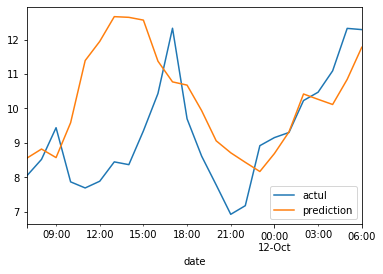

In [56]:
result = pd.DataFrame({'actul': y_chank})
result['prediction'] = pred
result.plot()

In [34]:
def print_coef(model):
    coef = pd.DataFrame(index=range(len(x_columns)))
    coef['featurs'] = x_columns
    coef['importance'] = model.coef_
    print(coef)